# Square-Octagon Fortress lattice

In [16]:
include("../functions.jl")
include("../plotting_functions.jl")
using LaTeXStrings
using JLD
using DataStructures
using LinearAlgebra

using Statistics
import Random
using ProgressMeter

In [17]:
k = 3
# Convergence is good for k=3, 
N =  4k + 1
if N%4 != 1
    error("N must be of the form 4k+1")
end

so_lat_full = get_so_lat(N, cell, oct)
so_lat_spin_full, latA, latB, sub_lat, G_to_spin, spin_to_G = get_so_lat_spin(so_lat_full)
# covering = get_perfect_covering(latA, latB,sub_lat, so_lat_full.nbr )
# config = convering_to_config(covering, so_lat_spin_full, G_to_spin);
noct_plaq = size(so_lat_spin_full.oct_plaq)[2]
nsq_plaq = size(so_lat_spin_full.sq_plaq)[2]
noct_plaq_pred = (N-1)^2
nsq_plaq_pred = (N-1)^2 + 1
if noct_plaq != noct_plaq_pred
    error("Number of octagonal plaquettes does not match prediction: $noct_plaq != $noct_plaq_pred")
end
if nsq_plaq != nsq_plaq_pred
    error("Number of square plaquettes does not match prediction: $nsq_plaq != $nsq_plaq_pred")
end

so_lat = Graph(so_lat_full.pts, fill(0,1,1), Vector{Vector{Int64}}[], so_lat_full.n, so_lat_full.sq_plaq, so_lat_full.oct_plaq,Vector{Vector{Int64}}[] )
so_lat_spin = Graph(so_lat_spin_full.pts, fill(0,1,1), Vector{Vector{Int64}}[], so_lat_spin_full.n, so_lat_spin_full.sq_plaq, so_lat_spin_full.oct_plaq,Vector{Vector{Int64}}[] )
config_vert = ordered_state(so_lat_spin, N, "vert")
config_hori = ordered_state(so_lat_spin, N, "hori");

  0.064293 seconds (341.85 k allocations: 13.682 MiB, 88.47% compilation time)
  0.002022 seconds (33.96 k allocations: 2.116 MiB)
  0.001151 seconds (1.30 k allocations: 86.562 KiB)


In [18]:
save("../data/fortress/lattice-data-$N.jld","so_lat", so_lat,
     "so_lat_spin", so_lat_spin,
     "config_vert", config_vert, "config_hori", config_hori)

In [19]:
config = config_vert # reset_config(covering, so_lat_spin, G_to_spin)
nstep = 1000_000
@time config = randomize_config(nstep, config, so_lat_spin.sq_plaq, so_lat_spin.oct_plaq)
;

  0.013519 seconds (2 allocations: 128 bytes)


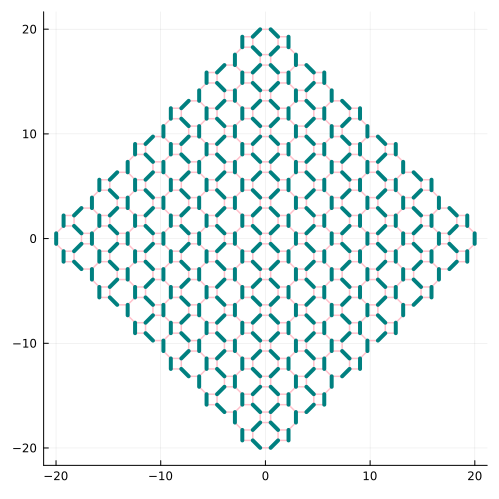

In [20]:
p = plot_generate(500)
# plot_graph(p,so_lattice, "pink",  2, :green)
plot_edges(p,so_lat_full, "pink", 1.5)
# plot_edges(p,so_lat_spin,"green")
config_vert = ordered_state(so_lat_spin, N, "vert")
config_hori = ordered_state(so_lat_spin, N, "hori");
# plot_config(p, config_hori,spin_to_G, so_lat)
plot_config(p, config_vert,spin_to_G, so_lat)
# plot!(xticks=false, yticks=false, framestyle=:none)
display(p)
;

In [21]:
oct_path =  findall(x -> (abs(imag(x) -0.5 - 0.5/sqrt(2)) < 1e-5 ), so_lat_spin.pts)
oct_path = sort_path_real(oct_path, so_lat_spin)

sq_path = findall(x -> (abs(imag(x)) < 1e-5 ), so_lat_spin.pts)
sq_path = sort_path_real(sq_path, so_lat_spin)

oct_diag_path = findall(x -> (abs(imag(x) + real(x) - 1 - 1/sqrt(2)) < 1e-5 ), so_lat_spin.pts)
oct_diag_path = sort_path_real(oct_diag_path, so_lat_spin)

# line = findall(x -> ( real(x) > 0) && (abs(imag(x)- 0.5 - 0.5/sqrt(2)) < 1e-5 ), so_lat_spin.pts)
# line1 = findall(x -> (abs(imag(x)) < 1e-5 ), so_lat_spin.pts)
# line2 = findall(x -> (abs(imag(x) -0.5 - 0.5/sqrt(2)) < 1e-5 ), so_lat_spin.pts)
# line3 = findall(x -> (abs(imag(x) -real(x)) < 1e-5 ), so_lat_spin.pts)
lines = [oct_path, sq_path, oct_diag_path]
label = [ "Octagon", "Square", "Octagon diagonal"]
origin = length(oct_path) ÷ 2 

12

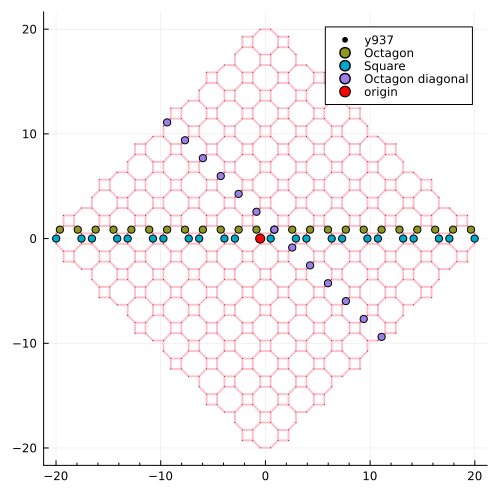

In [22]:

p = plot_generate(500)
plot_edges(p,so_lat_full)
scatter!(p,[real.(so_lat.pts)], [imag.(so_lat.pts)], color=:black, markersize=0.5)
for i in 1:3
    line = lines[i]
    scatter!(real.(so_lat_spin.pts[line]),imag.(so_lat_spin.pts[line]), label=label[i])
end


pt = so_lat_spin.pts[sq_path[origin]]
scatter!(p,[real(pt)], [imag(pt)], label="origin", color=:red, markersize=5)

plot!(legend=true)
# origin = -1 -1/sqrt(2) + 0.0im
# index_pts(so_lat_spin.pts, origin)
# plot!(ylim=(-2,2), xlim=(-2,2))
# scatter!([origin], [0])
# savefig(p,"./images/rect-square-oct.pdf")
plot!(xminorticks=5)
display(p)

# Monte Carlo

In [24]:
nstep = 1000_000_00
@time random_config = randomize_config(nstep, config_vert, so_lat_spin.sq_plaq, so_lat_spin.oct_plaq);

  1.353930 seconds (2 allocations: 128 bytes)


In [25]:

function sample_sz_line(running_sum::Vector{Int64}, config::Vector{Bool}, line::Vector{Int64}, nline::Int64)
    @simd for i in 1:nline
        if @inbounds config[line[i]]
            @inbounds running_sum[i] = running_sum[i] + 1
        end
    end
end

function sample_szsz_line(running_sum::Vector{Int64}, config::Vector{Bool}, line::Vector{Int64}, nline::Int64, origin::Int64)
    if @inbounds config[line[origin]]
        sample_sz_line(running_sum, config, line, nline)
    end
end

function init_vis_sampling(line1, origin::Int64)
    nline = length(line1)
    # origin = (nline + 1) ÷ 2
    line1_vis_right = line1[origin:end]
    line1_vis_left = reverse(line1[1:origin])
    vis_right = fill(0, length(line1_vis_right))
    vis_left = fill(0, length(line1_vis_left))

    return  line1_vis_left, line1_vis_right, length(line1_vis_left), length(line1_vis_right), vis_left, vis_right
end

    
function sample_vis_line(running_sum::Vector{Int64}, config::Vector{Bool}, line::Vector{Int64}, nline::Int64)
    curr_vis = 1
    for i in 1:nline
        if @inbounds config[line[i]]
            curr_vis = -curr_vis
        end
        @inbounds running_sum[i] = running_sum[i] + curr_vis
    end
end

sample_vis_line (generic function with 1 method)

In [26]:
function mc(config::Vector{Bool}, so_lat::Graph, so_lat_spin::Graph, nsample::Int64, nwait::Int64,lines::Vector{Vector{Int64}} )
    nsq = size(so_lat.sq_plaq)[2]
    noct = size(so_lat.oct_plaq)[2]
    nspin = length(config)
    plaq_sq_spin = so_lat_spin.sq_plaq
    plaq_oct_spin = so_lat_spin.oct_plaq
    
    oct_path, sq_path, oct_diag_path = lines
    path_lengths = length.([oct_path, sq_path, oct_diag_path])
    line_origin = length(oct_path) ÷ 2
    
    sz_lines = [fill(0, length(line)) for line in lines]

    szsz_lines = [fill(0, length(line)) for line in lines]

    # Random.seed!(1234)
    # printstyled("Random seed set to 1234. Change this if running on multiple threads.\n";color=:red)

    oct_line_vis_left, oct_line_vis_right, noct_line_vis_left, noct_line_vis_right, oct_vis_left, oct_vis_right = init_vis_sampling(oct_path, line_origin)
    sq1_line_vis_left, sq1_line_vis_right, nsq1_line_vis_left, nsq1_line_vis_right, sq1_vis_left, sq1_vis_right = init_vis_sampling(sq_path, line_origin)
    sq2_line_vis_left, sq2_line_vis_right, nsq2_line_vis_left, nsq2_line_vis_right, sq2_vis_left, sq2_vis_right = init_vis_sampling(sq_path, line_origin+1)
    oct_diag_origin = (length(oct_diag_path) + 1) ÷ 2
    oct_diag_line_vis_left, oct_diag_line_vis_right, noct_diag_line_vis_left, noct_diag_line_vis_right, oct_diag_vis_left, oct_diag_vis_right = init_vis_sampling(oct_diag_path, oct_diag_origin)
    # oct_diag_line_vis_left, oct_diag_line_vis_right, noct_diag_line_vis_left, noct_diag_line_vis_right, oct_diag_vis_left, oct_diag_vis_right = init_vis_sampling(oct_diag_path, line_origin)

    left_lines = [oct_line_vis_left, sq1_line_vis_left, sq2_line_vis_left, oct_diag_line_vis_left]
    right_lines = [oct_line_vis_right, sq1_line_vis_right, sq2_line_vis_right, oct_diag_line_vis_right]
    nleft_lines = [noct_line_vis_left, nsq1_line_vis_left, nsq2_line_vis_left, noct_diag_line_vis_left]
    nright_lines = [noct_line_vis_right, nsq1_line_vis_right, nsq2_line_vis_right, noct_diag_line_vis_right]
    vis_left = [oct_vis_left, sq1_vis_left, sq2_vis_left, oct_diag_vis_left]
    vis_right = [oct_vis_right, sq1_vis_right, sq2_vis_right, oct_diag_vis_right]


    # @showprogress 
    for i in 1:nsample
        for j in 1:nwait
            # if rand(Bool)
            #     plaq_oct_move(config,plaq_oct_spin, noct )
            # else
            #     plaq_sq_move(config,plaq_sq_spin, nsq )
            # end
            
            while !( (plaq_oct_move(config,plaq_oct_spin, noct ) == false) || (plaq_sq_move(config,plaq_sq_spin, nsq ) == false) )
            end
        end
        # Sample correlators
        
        for i in 1:3
            sample_sz_line(sz_lines[i], config, lines[i], path_lengths[i])
            sample_szsz_line(szsz_lines[i], config, lines[i], path_lengths[i], line_origin)
        end
        for i in 1:4
            sample_vis_line(vis_left[i], config, left_lines[i], nleft_lines[i])
            sample_vis_line(vis_right[i], config, right_lines[i], nright_lines[i])
        end
    end

    correlators = [sz_lines, szsz_lines, vis_left, vis_right] ./ nsample

    return config, correlators
end

mc (generic function with 1 method)

In [28]:
lines = [oct_path, sq_path, oct_diag_path]
# config_vert = get_vert_col_state(so_lat_rect_spin, so_lat_rect)
# config_hori = get_hori_col_state(so_lat_rect_spin, so_lat_rect)
nwait = 1000
nsample = 1000_000
cf = [config_hori, config_vert]
fn = ["./data/fortress/hori", "./data/fortress/vert"] .* "del"
nt = 2
corrs = [[] for _ in 1:length(fn)]
for i in 1:nt
    @time temp, corrs[i] = mc(cf[i], so_lat, so_lat_spin, nsample, nwait, lines)
end

 38.558682 seconds (105.82 k allocations: 5.371 MiB, 0.08% compilation time)
 38.441317 seconds (114 allocations: 8.172 KiB)


In [29]:
# save("./data/fortress/N=49, 100mil.jld", "hori_data", corrs[1], "vert_data", corrs[2])
# save("./data/fortress/N=23, 100mil.jld", "hori_data", corrs[1], "vert_data", corrs[2])
save("./data/fortress/test.jld", "hori_data", corrs[1], "vert_data", corrs[2])

# Data Processing and Plotting

In [30]:
hori_data, vert_data = load("./data/fortress/test.jld", "hori_data", "vert_data")
# hori_data, vert_data = load("./data/fortress/10mil.jld", "hori_data", "vert_data")

(Any[[[6.6e-5, 0.998147, 0.009014, 0.902367, 0.108459, 0.521351, 0.146381, 0.339273, 0.133763, 0.192762  …  0.192404, 0.133573, 0.338051, 0.146565, 0.522303, 0.108328, 0.902349, 0.008852, 0.998178, 4.9e-5], [0.999934, 0.000235, 0.989368, 0.028293, 0.822201, 0.214487, 0.589457, 0.318729, 0.524239, 0.397229  …  0.397834, 0.524024, 0.319546, 0.58947, 0.213732, 0.822522, 0.028501, 0.989546, 0.00022, 0.999951], [0.5473, 0.283485, 0.294507, 0.173584, 0.176964, 0.129254, 0.141497, 0.13003, 0.177146, 0.173134, 0.294333, 0.284056, 0.541796]], [[9.0e-6, 0.141707, 0.001318, 0.127882, 0.016355, 0.06985, 0.021082, 0.048222, 0.026051, 0.040609  …  0.036187, 0.021414, 0.050697, 0.021163, 0.074499, 0.015397, 0.128942, 0.001186, 0.14178, 6.0e-6], [0.429205, 8.6e-5, 0.424783, 0.01187, 0.354687, 0.089906, 0.255057, 0.135958, 0.230322, 0.165574  …  0.182211, 0.224397, 0.137909, 0.252306, 0.09137, 0.353263, 0.012355, 0.424717, 8.5e-5, 0.429221], [0.160394, 0.080236, 0.086145, 0.049304, 0.051338, 0.036641, 

## Sz

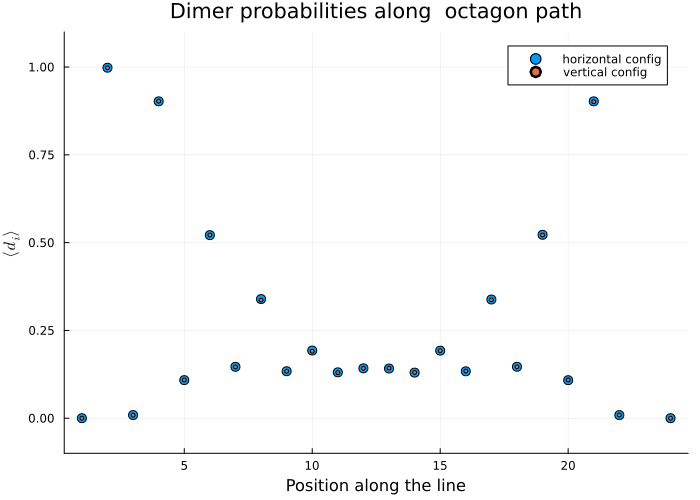

In [31]:
label = ["Oct","Sq", "Oct diag"]

p = plot(ylim=(-0.1,1.1), size=(700,500))
# p = plot_generate(500)
# plot!(ylim=(-0.1,1.1), aspect_ratio=false)
for i in 1
    scatter!(hori_data[1][i], label= "horizontal config", markersize=5)
    scatter!(vert_data[1][i], label= "vertical config", markershape=:o, markersize=2)
end
plot!(xlabel="Position along the line", ylabel=L"\langle d_i \rangle", title="Dimer probabilities along  octagon path")
display(p)

## Szsz

In [32]:
hori_oct_szsz = abs.(hori_data[2][1] .- hori_data[1][1] * hori_data[1][1][origin])
hori_sq_szsz = abs.(hori_data[2][2] .- hori_data[1][2] * hori_data[1][2][origin])
hori_oct_diag_szsz = abs.(hori_data[2][3] .- hori_data[1][3] * hori_data[1][3][origin]);

vert_oct_szsz = abs.(vert_data[2][1] .- vert_data[1][1] * vert_data[1][1][origin])
vert_sq_szsz = abs.(vert_data[2][2] .- vert_data[1][2] * vert_data[1][2][origin])
vert_oct_diag_szsz = abs.(vert_data[2][3] .- vert_data[1][3] * vert_data[1][3][origin]);

d_oct = abs.([i - origin for i in 1:length(oct_path)])
d_sq = abs.([i - origin for i in 1:length(sq_path)])
d_oct_diag = abs.([i - origin for i in 1:length(oct_diag_path)])
;

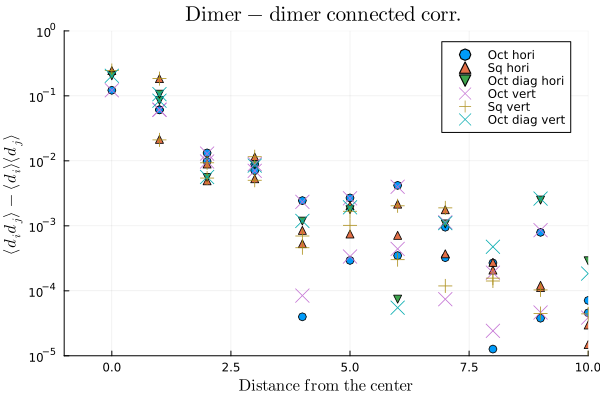

In [33]:
p = plot(yaxis=:log, ylims=(1e-5, 1e0),xlim=(-1,10), title="SzSz Connected", xlabel="Distance", ylabel="<SzSz>_c")

scatter!(d_oct, hori_oct_szsz, label="Oct hori", markershape=:o)
scatter!(d_sq, hori_sq_szsz, label="Sq hori", markershape=:^)
scatter!(d_oct_diag, hori_oct_diag_szsz, label="Oct diag hori", markershape=:v)

scatter!(d_oct, vert_oct_szsz, label="Oct vert", markershape=:x, markersize=7)
scatter!(d_sq, vert_sq_szsz, label="Sq vert", markershape=:+, markersize=7)
scatter!(d_oct_diag, vert_oct_diag_szsz, label="Oct diag vert", markershape=:x, markersize=7)
plot!(xlabel=L"\textrm{Distance~from~the~center}", ylabel=L"\langle d_i d_j\rangle - \langle d_i\rangle\langle d_j\rangle", title=L"\textrm{Dimer-dimer~connected~corr.}")



## Vison

In [34]:
hori_oct_vis_left = abs.(hori_data[3][1])
hori_oct_vis_right = abs.(hori_data[4][1])
hori_sq1_vis_left = abs.(hori_data[3][2])
hori_sq1_vis_right = abs.(hori_data[4][2])
hori_sq2_vis_left = abs.(hori_data[3][3])
hori_sq2_vis_right = abs.(hori_data[4][3])
hori_oct_diag_vis_left = abs.(hori_data[3][4])
hori_oct_diag_vis_right = abs.(hori_data[4][4])

vert_oct_vis_left = abs.(vert_data[3][1])
vert_oct_vis_right = abs.(vert_data[4][1])
vert_sq1_vis_left = abs.(vert_data[3][2])
vert_sq1_vis_right = abs.(vert_data[4][2])
vert_sq2_vis_left = abs.(vert_data[3][3])
vert_sq2_vis_right = abs.(vert_data[4][3])
vert_oct_diag_vis_left = abs.(vert_data[3][4])
vert_oct_diag_vis_right = abs.(vert_data[4][4])


oct_vis = avg(hori_oct_vis_left, vert_oct_vis_left)
;

### Octagon path

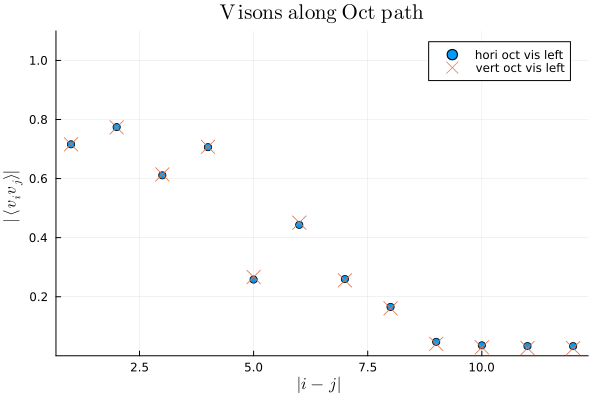

In [36]:
p = plot(ylims=(1e-4, 1.1), title="Visons", xlabel="Distance", ylabel="<Vis>")
scatter!(hori_oct_vis_left, label="hori oct vis left")
# scatter!(hori_oct_vis_right, label="hori oct vis right")
# scatter!(hori_oct_diag_vis_left, label="hori oct diag vis left")
# scatter!(hori_oct_diag_vis_right, label="hori oct diag vis right")

# Add vertical data to the plot
scatter!(vert_oct_vis_left, label="vert oct vis left", markershape=:x, markersize=7)
# scatter!(vert_oct_vis_right, label="vert oct vis right")
# scatter!(vert_oct_diag_vis_left, label="vert oct diag vis left")
# scatter!(vert_oct_diag_vis_right, label="vert oct diag vis right")
plot!(ylims=(1e-4, 1.1), title=L"\textrm{Visons~along~Oct~path}", xlabel=L"|i-j|", ylabel=L"|\langle v_i v_j \rangle |")

# Display the plot
display(p)

### Square 2 path

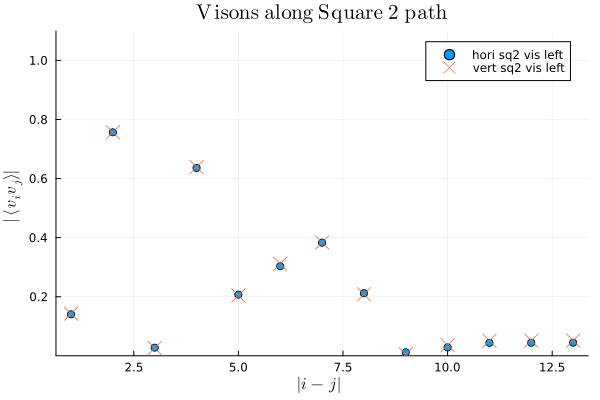

In [37]:
p = plot(ylims=(1e-4, 1.1), title="Visons", xlabel="Distance", ylabel="<Vis>")
# plot!(yaxis=:log)
# scatter!(hori_sq1_vis_left, label="hori sq1 vis left")
# scatter!(hori_sq1_vis_right, label="hori sq1 vis right")
scatter!(hori_sq2_vis_left, label="hori sq2 vis left")
# scatter!(hori_sq2_vis_right, label="hori sq2 vis right")


# Add vertical data to the plot

# scatter!(vert_sq1_vis_left, label="vert sq1 vis left")
# scatter!(vert_sq1_vis_right, label="vert sq1 vis right")
scatter!(vert_sq2_vis_left, label="vert sq2 vis left", markershape=:x, markersize=7)
# scatter!(vert_sq2_vis_right, label="vert sq2 vis right")
plot!(ylims=(1e-4, 1.1), title=L"\textrm{Visons~along~Square~2~path}", xlabel=L"|i-j|", ylabel=L"|\langle v_i v_j \rangle |")


# Display the plot
display(p)

In [38]:
oct_vis = avg(hori_oct_vis_left, vert_oct_vis_left)
sq1_vis = avg(hori_sq1_vis_left, hori_sq2_vis_right, vert_sq1_vis_left, vert_sq2_vis_right)
sq2_vis = avg(hori_sq1_vis_right, hori_sq2_vis_left, vert_sq1_vis_right, vert_sq2_vis_left)
# oct_diag_vis = avg(hori_oct_diag_vis_left,hori_oct_diag_vis_right, vert_oct_diag_vis_left, vert_oct_diag_vis_right)
oct_diag_vis = avg(hori_oct_diag_vis_left, vert_oct_diag_vis_left)
;

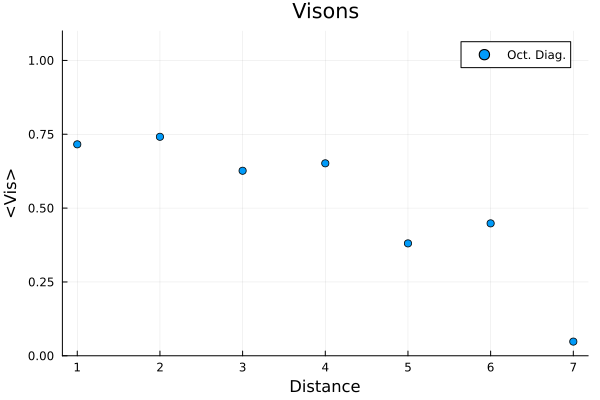

In [39]:
p = plot(ylims=(0.0, 1.1), title="Visons", xlabel="Distance", ylabel="<Vis>")

# scatter!(oct_vis, label="Oct.")
scatter!(oct_diag_vis, label="Oct. Diag.")


# Display the plot
display(p)

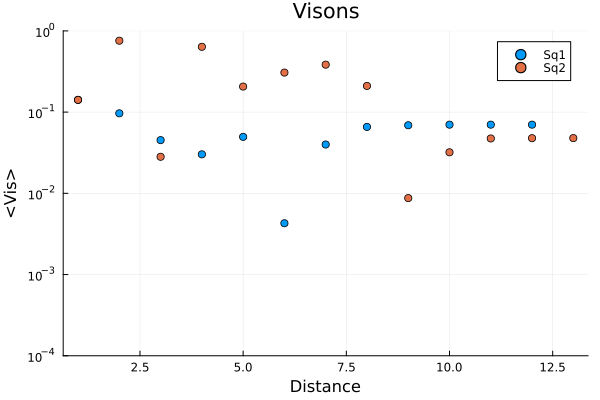

In [40]:
p = plot(yaxis=:log, ylims=(1e-4, 1), title="Visons", xlabel="Distance", ylabel="<Vis>")

scatter!(sq1_vis, label="Sq1")
scatter!(sq2_vis, label="Sq2")


# Display the plot
display(p)